# Introduction to inverse kinematics (i.e., inverse geometry)

## Load and display a robot

Do imports.

In [2]:
# Rigid body dynamics (pinocchio)
import pinocchio as pin

# Visualization (meshcat)
from pinocchio.visualize import MeshcatVisualizer
import meshcat_shapes

# Robot models (robot_descriptions)
from robot_descriptions.loaders.pinocchio import load_robot_description

# Math ("expm" is the matrix exponential function)
import numpy as np
from scipy.linalg import expm, logm

# Timing
import time

# Plots
import matplotlib.pyplot as plt

# Interaction
import ipywidgets as widgets
from IPython.display import display

# Suppress the display of very small numbers
np.set_printoptions(suppress=True)

Load a robot model and show how many joints there are.

In [3]:
# Load model
robot = load_robot_description(
    'iiwa14_description',           # name of robot model
    root_joint=None,                # fixed base
)

# Show number of joints
print(f'There are {robot.nq} joints.')

There are 7 joints.


Print a list of all frames.

In [4]:
print('FRAMES\n')
for frame in robot.model.frames:
    print(f' {frame.name}')

FRAMES

 universe
 base
 iiwa_base_joint
 iiwa_link_0
 iiwa_joint_1
 iiwa_link_1
 iiwa_joint_2
 iiwa_link_2
 iiwa_joint_3
 iiwa_link_3
 iiwa_joint_4
 iiwa_link_4
 iiwa_joint_5
 iiwa_link_5
 iiwa_joint_6
 iiwa_link_6
 iiwa_joint_7
 iiwa_link_7
 iiwa_joint_ee
 iiwa_link_ee_kuka
 tool0_joint
 iiwa_link_ee


Display robot in browser.

In [5]:
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Choose what to display
vis.displayFrames(False)
vis.displayVisuals(True)
vis.displayCollisions(False)

# Add our own frames to the visualizer because the default frames are hard to see
# # - All frames
# frames_to_show = [
#     'iiwa_link_0',
#     'iiwa_link_1',
#     'iiwa_link_2',
#     'iiwa_link_3',
#     'iiwa_link_4',
#     'iiwa_link_5',
#     'iiwa_link_6',
#     'iiwa_link_7',
#     'iiwa_link_ee_kuka',
# ]
# - Just the space frame and body frame
frames_to_show = [
    'iiwa_link_0',
    'iiwa_link_ee_kuka',
]
for frame in frames_to_show:
    meshcat_shapes.frame(vis.viewer['frames/' + frame], opacity=1.0, axis_length=0.2)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Put the robot at its "neutral" configuration.

In [6]:
# Get and show the neutral configuration (most likely all zeros)
q = pin.neutral(robot.model)
print(f'{q = }')

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

q = array([0., 0., 0., 0., 0., 0., 0.])


Create sliders that allow us to change the configuration.

In [7]:
# Callback function that receives all 7 slider values
def on_slider_change(change):
    q = np.deg2rad(np.array([slider.value for slider in sliders]))
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(q)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Create 7 sliders
sliders = []
for i in range(7):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

## Do examples of inverse kinematics

### Set up the problem

Choose a desired pose.

In [8]:
# Choose a desired pose
T_0_D = np.array([[1., 0., 0., 0.3],
                  [0., 1., 0., 0.4],
                  [0., 0., 1., 0.5],
                  [0., 0., 0., 1.]])

# Show desired pose in the browser window
meshcat_shapes.frame(vis.viewer['frames/' + 'desired_pose'], opacity=1.0, axis_length=0.2)
vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)


Choose an initial configuration (in this case, at random).

In [9]:
q0 = pin.randomConfiguration(robot.model)

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q0)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q0)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

### Show that we must be careful about computing derivatives

Define functions that get the cost and the gradient of the cost for inverse kinematics, both analytically and by finite difference.

In [10]:
def get_ik_cost_and_gradient_pin(q, B):
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    A = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous
    pin.computeJointJacobians(robot.model, robot.data)
    J_b = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.LOCAL)
    v_b_error = np.array(pin.log6(pin.SE3(np.linalg.inv(A) @ B)))
    Jlog6 = pin.Jlog6(pin.SE3(np.linalg.inv(B) @ A))
    return (1/2) * np.dot(v_b_error, v_b_error), - J_b.T @ v_b_error, - J_b.T @ Jlog6.T @ v_b_error

def get_ik_gradient_finite_diff_pin(q, B, alpha=0.01):
    c0, ga1, ga2 = get_ik_cost_and_gradient_pin(q, B)
    gn = np.zeros(len(q))
    for k in range(len(q)):
        dq = alpha * np.eye(1, 7, k=k).flatten()
        c1, ga1, ga2 = get_ik_cost_and_gradient_pin(q + dq, B)
        gn[k] = (c1 - c0) / alpha
    return gn

def get_ik_gradients(q, B, alpha=0.01):
    c, ga1, ga2 = get_ik_cost_and_gradient_pin(q, T_0_D)
    gn = get_ik_gradient_finite_diff_pin(q, T_0_D, alpha=alpha)
    return ga1, ga2, gn

Compare the analytical gradient (both with and without the Jacobian of log term) with the finite difference approximation.

GRADIENTS FOR ALPHA=0.01
 ga1 = [ 2.4903 -0.4716 -0.4524 -1.8863 -0.3929 -0.1915  1.7309]
 ga2 = [ 1.9214 -0.2924 -0.3193 -1.8518 -0.2664 -0.1341  2.0307]
  gn = [ 1.9249 -0.2906 -0.3155 -1.8479 -0.2626 -0.13    2.0369]


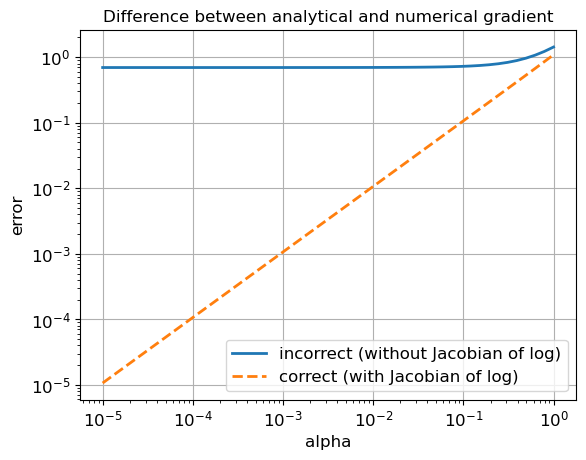

In [11]:
# Compute the gradient of the IK cost function in three ways
# 1) Analytically, without the Jacobian of log term
# 2) Analytically, with the Jacobian of log term
# 3) Numerically, by finite difference with a step size alpha=0.01
ga1, ga2, gn = get_ik_gradients(q0, T_0_D, alpha=0.01)
print(f'GRADIENTS FOR ALPHA={0.01}')
with np.printoptions(precision=4):
    print(f' ga1 = {ga1}')
    print(f' ga2 = {ga2}')
    print(f'  gn = {gn}')

# Repeat for a wide range of step sizes
h = []
ea1 = []
ea2 = []
for alpha in np.logspace(-5, 0, 50):
    ga1, ga2, gn = get_ik_gradients(q0, T_0_D, alpha=alpha)
    h.append(alpha)
    ea1.append(np.linalg.norm(ga1 - gn))
    ea2.append(np.linalg.norm(ga2 - gn))
ea1 = np.array(ea1)
ea2 = np.array(ea2)

# Plot difference between analytical and numerical results
plt.plot(h, ea1, linewidth=2, label='incorrect (without Jacobian of log)')
plt.plot(h, ea2, '--', linewidth=2, label='correct (with Jacobian of log)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('alpha', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.title('Difference between analytical and numerical gradient', fontsize=12)
plt.show()

### Solve the problem by gradient descent

Define function to solve IK problem by gradient descent.

In [12]:
def solve_ik_gradient_descent(q0, T_0_D, use_correct_derivative=True):
    # Initial configuration
    q = q0.copy()

    # Max number of iterations
    max_iters = 1e5

    # Step size
    alpha = 0.1

    # Tolerance
    e_tol = 1e-4

    # Array to store errors
    e = []

    # Current number of iterations
    num_iters = 0

    while True:
        c, ga1, ga2 = get_ik_cost_and_gradient_pin(q, T_0_D)

        # Get and store current error
        e_cur = np.sqrt(2 * c) # FIXME
        e.append(float(e_cur))

        # Check if stopping criterion is met
        if e_cur < e_tol:
            print(f'SUCCESS (in {num_iters} iterations)')
            break

        # Check if maximum number of iterations has been reached
        if num_iters > max_iters:
            print(f'FAILURE (exceeded {max_iters} iterations)')
            break
        
        # Do one step of gradient descent
        if use_correct_derivative:
            q -= alpha * ga2
        else:
            q -= alpha * ga1

        # Increment number of iterations
        num_iters += 1

        # Update display
        pin.forwardKinematics(robot.model, robot.data, q)
        pin.updateFramePlacements(robot.model, robot.data)
        vis.display(q)
        for frame in frames_to_show:
            frame_id = robot.model.getFrameId(frame)
            vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
        vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)
    
    return q, e

Apply function, both with and without the correct gradient.

In [13]:
print('Solve with incorrect gradient...')
q1, e1 = solve_ik_gradient_descent(q0, T_0_D, use_correct_derivative=False)
print('')
print('Solve with correct gradient...')
q2, e2 = solve_ik_gradient_descent(q0, T_0_D, use_correct_derivative=True)

Solve with incorrect gradient...
SUCCESS (in 1417 iterations)

Solve with correct gradient...
SUCCESS (in 1234 iterations)


Plot error as a function of iteration.

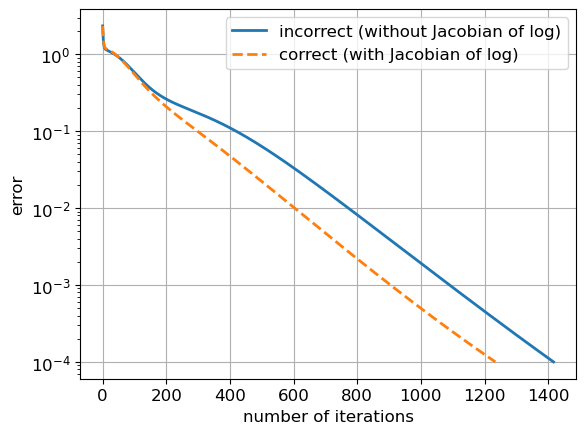

In [14]:
plt.plot(e1, linewidth=2, label='incorrect (without Jacobian of log)')
plt.plot(e2, '--', linewidth=2, label='correct (with Jacobian of log)')
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

### Solve the problem by Gauss-Newton

Define a function to get the residual and the (body-frame) Jacobian of the residual.

In [15]:
def get_ik_residual_and_jacobian(q, B, use_correct_derivative=True):
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    A = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous
    pin.computeJointJacobians(robot.model, robot.data)
    J_b = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.LOCAL)
    v_b_error = np.array(pin.log6(pin.SE3(np.linalg.inv(A) @ B)))
    Jlog6 = pin.Jlog6(pin.SE3(np.linalg.inv(B) @ A))
    if use_correct_derivative:
        return v_b_error, -Jlog6 @ J_b
    else:
        return v_b_error, -J_b

Define a function to solve the problem by Gauss-Newton.

In [16]:
def solve_ik_gauss_newton(q0, T_0_D, use_correct_derivative=True, alpha=0.1):
    # Initial configuration
    q = q0.copy()

    # Max number of iterations
    max_iters = 1e5
    
    # Tolerance
    e_tol = 1e-4

    # Array to store errors
    e = []

    # Current number of iterations
    num_iters = 0

    while True:
        r, J = get_ik_residual_and_jacobian(q, T_0_D, use_correct_derivative=use_correct_derivative)
        
        # Get and store current error
        e_cur = (1 / 2) * np.dot(r, r)
        e.append(float(e_cur))

        # Check if stopping criterion is met
        if e_cur < e_tol:
            print(f'SUCCESS (in {num_iters} iterations)')
            break

        # Check if maximum number of iterations has been reached
        if num_iters > max_iters:
            print(f'FAILURE (exceeded {max_iters} iterations)')
            break
        
        # Do one step of LM
        dq = - np.linalg.inv(J.T @ J) @ J.T @ r
        q += alpha * dq

        # Increment number of iterations
        num_iters += 1

        # Update display
        pin.forwardKinematics(robot.model, robot.data, q)
        pin.updateFramePlacements(robot.model, robot.data)
        vis.display(q)
        for frame in frames_to_show:
            frame_id = robot.model.getFrameId(frame)
            vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
        vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)
    
    return q, e

Solve the problem.

In [17]:
q1, e1 = solve_ik_gauss_newton(q0, T_0_D, use_correct_derivative=False, alpha=0.1)
q2, e2 = solve_ik_gauss_newton(q0, T_0_D, use_correct_derivative=True, alpha=0.1)

SUCCESS (in 145 iterations)
SUCCESS (in 155 iterations)


Plot error.

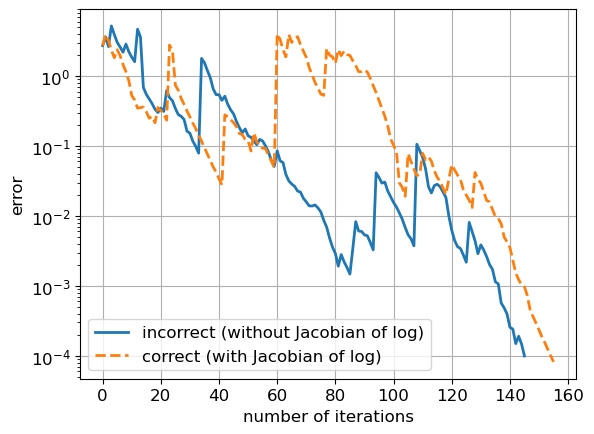

In [18]:
plt.plot(e1, linewidth=2, label='incorrect (without Jacobian of log)')
plt.plot(e2, '--', linewidth=2, label='correct (with Jacobian of log)')
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

### Solve the problem by Levenberg-Marquardt

Define a function to solve the problem by Levenberg-Marquardt.

In [19]:
def solve_ik_levenberg_marquardt(q0, T_0_D, use_correct_derivative=True, gamma=0.1, e_tol=1e-4):
    # Initial configuration
    q = q0.copy()

    # Max number of iterations
    max_iters = 1e5

    # Array to store errors
    e = []

    # Current number of iterations
    num_iters = 0

    while True:
        r, J = get_ik_residual_and_jacobian(q, T_0_D, use_correct_derivative=use_correct_derivative)
        
        # Get and store current error
        e_cur = (1 / 2) * np.dot(r, r)
        e.append(float(e_cur))

        # Check if stopping criterion is met
        if e_cur < e_tol:
            print(f'SUCCESS (in {num_iters} iterations)')
            break

        # Check if maximum number of iterations has been reached
        if num_iters > max_iters:
            print(f'FAILURE (exceeded {max_iters} iterations)')
            break
        
        # Do one step of LM
        dq = - np.linalg.inv(J.T @ J + gamma * np.identity(len(q))) @ J.T @ r
        q += dq

        # Increment number of iterations
        num_iters += 1

        # Update display
        pin.forwardKinematics(robot.model, robot.data, q)
        pin.updateFramePlacements(robot.model, robot.data)
        vis.display(q)
        for frame in frames_to_show:
            frame_id = robot.model.getFrameId(frame)
            vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
        vis.viewer['frames/' + 'desired_pose'].set_transform(T_0_D)
    
    return q, e

Solve the problem.

In [20]:
q1, e1 = solve_ik_levenberg_marquardt(q0, T_0_D, use_correct_derivative=False, gamma=0.1, e_tol=1e-4)
q2, e2 = solve_ik_levenberg_marquardt(q0, T_0_D, use_correct_derivative=True, gamma=0.1, e_tol=1e-4)

SUCCESS (in 16 iterations)
SUCCESS (in 13 iterations)


Plot error.

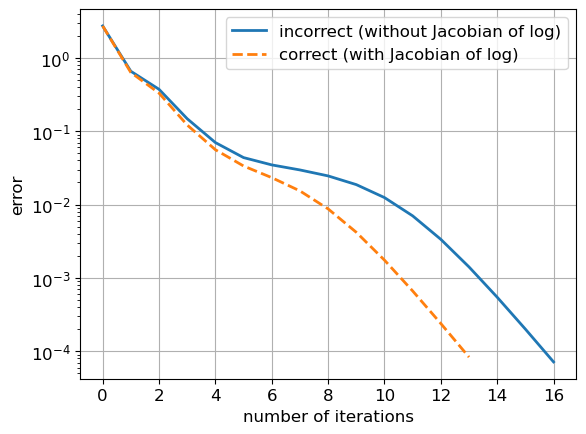

In [21]:
plt.plot(e1, linewidth=2, label='incorrect (without Jacobian of log)')
plt.plot(e2, '--', linewidth=2, label='correct (with Jacobian of log)')
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()